### **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Define the Dataset**

In [2]:
class FunctionDataset(Dataset):
  """Simple class to create a dataset with features and labels."""
  def __init__(self, num_samples=1000, noise=0.1):
    """
    Parameters
    ----------
    num_samples (int): Number of samples to generate.
    noise (float or int): Noise coefficients to add to the labels
    """
    self.x = torch.linspace(-50, 50, num_samples*2).view(-1, 2)
    # Calculate y values from f(x, y) = 2x + 3y with some noise
    self.y = (2*self.x[:, 0] + 3*self.x[:, 1] + noise*torch.randn(num_samples)).view(-1, 1)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [3]:
# Create dataset instance
dataset = FunctionDataset(num_samples=1000)

print(f"Dataset samples: {len(dataset)}, Features: {dataset.x.shape[1]}, Label: {dataset.y.shape[1]}\n")
print(f"First 5 input features: \n{dataset.x[:5]}\n")
print(f"First 5 output labels: \n{dataset.y[:5]}")

Dataset samples: 1000, Features: 2, Label: 1

First 5 input features: 
tensor([[-50.0000, -49.9500],
        [-49.8999, -49.8499],
        [-49.7999, -49.7499],
        [-49.6998, -49.6498],
        [-49.5998, -49.5498]])

First 5 output labels: 
tensor([[-249.6919],
        [-249.3762],
        [-248.7987],
        [-248.3144],
        [-248.1487]])


### **Split the Dataset**

In [4]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create train, validation and test loader for batch processing
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

print(f"Train set size: {len(train_set)}\nValidation set size: {len(val_set)}\nTest set size: {len(test_set)}")

Train set size: 800
Validation set size: 100
Test set size: 100


### **Define the Neural Network Model**

In [5]:
class SimpleNN(nn.Module):
  """Simple class to create a neural network."""
  def __init__(self):
    """Define model with one hidden layer and ReLu activation function"""
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

  def forward(self, x):
    return self.fc(x)

# Create model instance
model = SimpleNN()
print(model)

SimpleNN(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### **Define Loss Function and Optimizer**

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### **Train and Validate the Model**

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
  train_losses = []
  val_losses = []
  weights = []
  biases = []

  for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0

    for X, y in train_loader:
      optimizer.zero_grad()
      predictions = model(X)
      loss = criterion(predictions, y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    # Store weights and biases
    with torch.no_grad():
      weights.append(model.fc[0].weight.clone().detach().numpy())
      biases.append(model.fc[0].bias.clone().detach().numpy())

    # Validation phase
    model.eval()
    val_loss = 0

    with torch.no_grad():
      for X, y in val_loader:
        predictions = model(X)
        loss = criterion(predictions, y)
        val_loss += loss.item()

    # Add average losses to the list
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    if (epoch+1) % 5 == 0:
      print(f"Epoch {(epoch+1)}/{epochs}, Train loss: {train_losses[epoch]:5f}, Validation loss: {val_losses[epoch]:.5f}")

  return weights, biases, train_losses, val_losses

weights, biases, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 5/50, Train loss: 16811.667227, Validation loss: 13959.62036
Epoch 10/50, Train loss: 12938.288418, Validation loss: 10430.73035
Epoch 15/50, Train loss: 8451.078301, Validation loss: 6497.33612
Epoch 20/50, Train loss: 4316.366807, Validation loss: 3113.66248
Epoch 25/50, Train loss: 1584.831357, Validation loss: 1061.54890
Epoch 30/50, Train loss: 389.193906, Validation loss: 239.21257
Epoch 35/50, Train loss: 61.300701, Validation loss: 34.09432
Epoch 40/50, Train loss: 6.423045, Validation loss: 3.36538
Epoch 45/50, Train loss: 0.697128, Validation loss: 0.44789
Epoch 50/50, Train loss: 0.266172, Validation loss: 0.25619


### **Visualize Weight and Bias Updates**

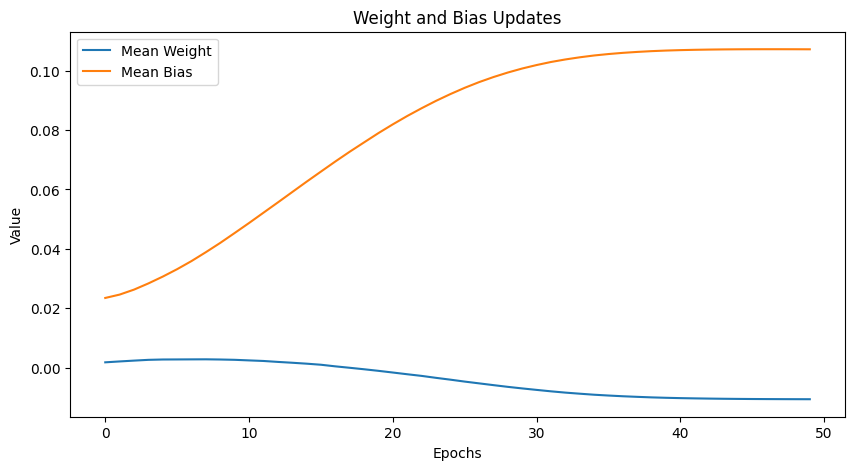

In [8]:
# Prepare weights and biases for plotting
weights = np.array(weights)
biases = np.array(biases)

# Average weights and biases for each epoch
mean_weights = np.mean(weights, axis=(1, 2))
mean_biases = np.mean(biases, axis=1)

# Plot the weights and biases
plt.figure(figsize=(10, 5))
plt.plot(mean_weights, label="Mean Weight")
plt.plot(mean_biases, label="Mean Bias")
plt.title("Weight and Bias Updates")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()


### **Visualize Train and Validation Loss**

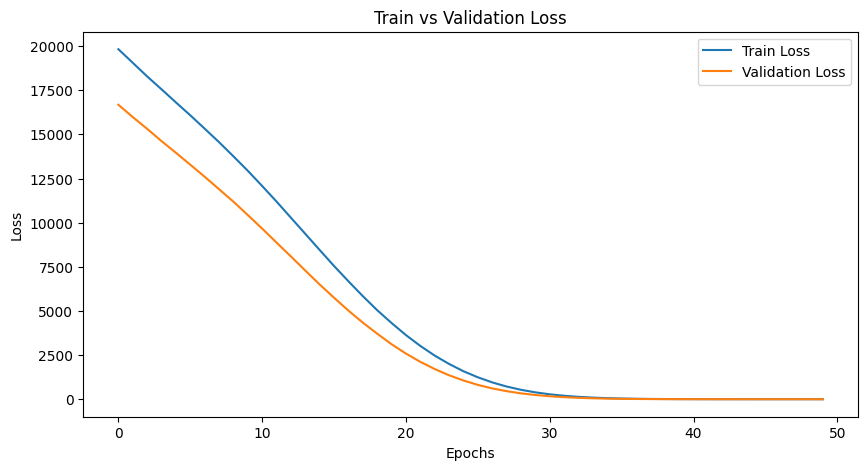

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **Test the Model**

In [10]:
def test_model(model, test_loader, criterion, optimizer):
  model.eval()
  all_targets = []
  all_predictions = []

  with torch.no_grad():
    test_loss = 0
    for X, y in test_loader:
      predictions = model(X)
      loss = criterion(predictions, y)
      test_loss += loss.item()
      all_targets.append(y.squeeze())
      all_predictions.append(predictions.squeeze())

  return test_loss / len(test_loader), all_targets, all_predictions

test_loss, all_targets, all_predictions = test_model(model, test_loader, criterion, optimizer)
print(f"Test Loss: {test_loss / len(test_loader):.5f}")

Test Loss: 0.06703


### **Visualize Targets and Predictions**

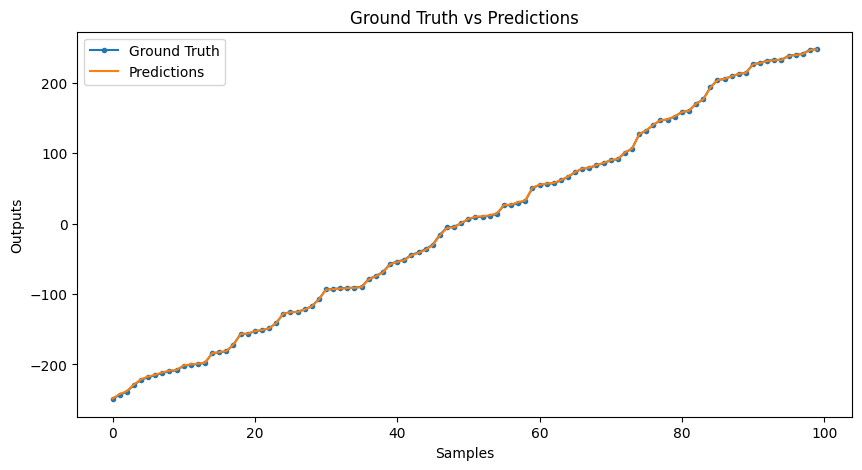

In [11]:
# Prepare targets and predictions for plotting
all_targets = torch.cat(all_targets).numpy()
all_predictions = torch.cat(all_predictions).numpy()

# Sort targets for better visualization
indices = np.argsort(all_targets)
all_targets = all_targets[indices]
all_predictions = all_predictions[indices]

# Plot the predictions and targets
plt.figure(figsize=(10, 5))
plt.plot(all_targets, label="Ground Truth", marker=".")
plt.plot(all_predictions, label="Predictions")
plt.title("Ground Truth vs Predictions")
plt.xlabel("Samples")
plt.ylabel("Outputs")
plt.legend()
plt.show()

### **More Neural Networks**

**Shalow Network**

In [12]:
class ShallowNN(nn.Module):
  """Simple class to create a neural network."""
  def __init__(self):
    """Define model with no hidden layer and ReLu activation function"""
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(2, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

  def forward(self, x):
    return self.fc(x)

# Create model instance
shallow_model = ShallowNN()

**Deep Network**

In [13]:
class DeepNN(nn.Module):
  """Simple class to create a neural network."""
  def __init__(self):
    """Define model with two hidden layers and ReLu activation function"""
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

  def forward(self, x):
    return self.fc(x)

# Create model instance
deep_model = DeepNN()

**Network with Tanh Activation**

In [14]:
class TanhNN(nn.Module):
  """Simple class to create a neural network."""
  def __init__(self):
    """Define model with one hidden layer and Tanh activation function"""
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(2, 64),
        nn.Tanh(),
        nn.Linear(64, 64),
        nn.Tanh(),
        nn.Linear(64, 1)
    )

  def forward(self, x):
    return self.fc(x)

# Create model instance
tanh_model = TanhNN()

**Network with Dropout**

In [15]:
class DropoutNN(nn.Module):
  """Simple class to create a neural network."""
  def __init__(self):
    """Define model with one hidden layer, ReLu activation function and Dropout layers"""
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1)
    )

  def forward(self, x):
    return self.fc(x)

# Create model instance
dropout_model = DropoutNN()

### **Train All Models**

In [16]:
# Train shallow network
print("Shallow Network")
optimizer_shallow = optim.Adam(shallow_model.parameters(), lr = 0.0001)
weights_shallow, biases_shallow, train_losses_shallow, val_losses_shallow = train_model(shallow_model, train_loader, val_loader, criterion, optimizer_shallow)

# Train deep network
print("\nDeep Network")
optimizer_deep = optim.Adam(deep_model.parameters(), lr = 0.0001)
weights_deep, biases_deep, train_losses_deep, val_losses_deep = train_model(deep_model, train_loader, val_loader, criterion, optimizer_deep)

# Train tanh network
print("\nTanh Network")
optimizer_tanh = optim.Adam(tanh_model.parameters(), lr = 0.0001)
weights_tanh, biases_tanh, train_losses_tanh, val_losses_tanh = train_model(tanh_model, train_loader, val_loader, criterion, optimizer_tanh)

# Train dropout network
print("\nDropout Network")
optimizer_dropout = optim.Adam(dropout_model.parameters(), lr = 0.0001)
weights_dropout, biases_dropout, train_losses_dropout, val_losses_dropout = train_model(dropout_model, train_loader, val_loader, criterion, optimizer_dropout)

Shallow Network
Epoch 5/50, Train loss: 20397.750039, Validation loss: 18005.87549
Epoch 10/50, Train loss: 19236.674609, Validation loss: 16950.28809
Epoch 15/50, Train loss: 18111.699297, Validation loss: 15937.39282
Epoch 20/50, Train loss: 17007.466250, Validation loss: 14946.10840
Epoch 25/50, Train loss: 15926.980352, Validation loss: 13978.57788
Epoch 30/50, Train loss: 14850.902305, Validation loss: 13018.48901
Epoch 35/50, Train loss: 13772.554336, Validation loss: 12061.57104
Epoch 40/50, Train loss: 12687.555000, Validation loss: 11100.95581
Epoch 45/50, Train loss: 11608.832734, Validation loss: 10151.55151
Epoch 50/50, Train loss: 10541.471992, Validation loss: 9220.50256

Deep Network
Epoch 5/50, Train loss: 17969.544336, Validation loss: 14949.27539
Epoch 10/50, Train loss: 8390.777578, Validation loss: 5961.49628
Epoch 15/50, Train loss: 484.477983, Validation loss: 207.54942
Epoch 20/50, Train loss: 0.685629, Validation loss: 0.28801
Epoch 25/50, Train loss: 0.157975, 

### **Visualize Weight and Bias Updates for All Models**

**Prepare Weights and Biases**

In [17]:
# Average weights and biases for each epoch
# Shallow network
weights_shallow = np.array(weights_shallow)
biases_shallow = np.array(biases_shallow)
mean_weights_shallow = np.mean(weights_shallow, axis=(1, 2))
mean_biases_shallow = np.mean(biases_shallow, axis=1)

# Deep network
weights_deep = np.array(weights_deep)
biases_deep = np.array(biases_deep)
mean_weights_deep = np.mean(weights_deep, axis=(1, 2))
mean_biases_deep = np.mean(biases_deep, axis=1)

# Tanh network
weights_tanh = np.array(weights_tanh)
biases_tanh = np.array(biases_tanh)
mean_weights_tanh = np.mean(weights_tanh, axis=(1, 2))
mean_biases_tanh = np.mean(biases_tanh, axis=1)

# Dropout network
weights_dropout = np.array(weights_dropout)
biases_dropout = np.array(biases_dropout)
mean_weights_dropout = np.mean(weights_dropout, axis=(1, 2))
mean_biases_dropout = np.mean(biases_dropout, axis=1)

**Plot Weights and Biases**

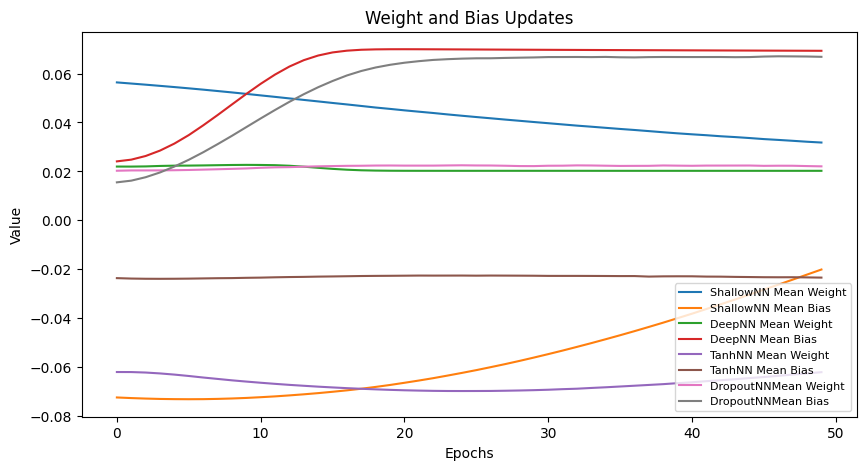

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(mean_weights_shallow, label="ShallowNN Mean Weight")
plt.plot(mean_biases_shallow, label="ShallowNN Mean Bias")
plt.plot(mean_weights_deep, label="DeepNN Mean Weight")
plt.plot(mean_biases_deep, label="DeepNN Mean Bias")
plt.plot(mean_weights_tanh, label="TanhNN Mean Weight")
plt.plot(mean_biases_tanh, label="TanhNN Mean Bias")
plt.plot(mean_weights_dropout, label="DropoutNNMean Weight")
plt.plot(mean_biases_dropout, label="DropoutNNMean Bias")
plt.title("Weight and Bias Updates")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(loc="lower right", fontsize=8)
plt.show()


### **Visualize Train and Validation Loss for All Models**

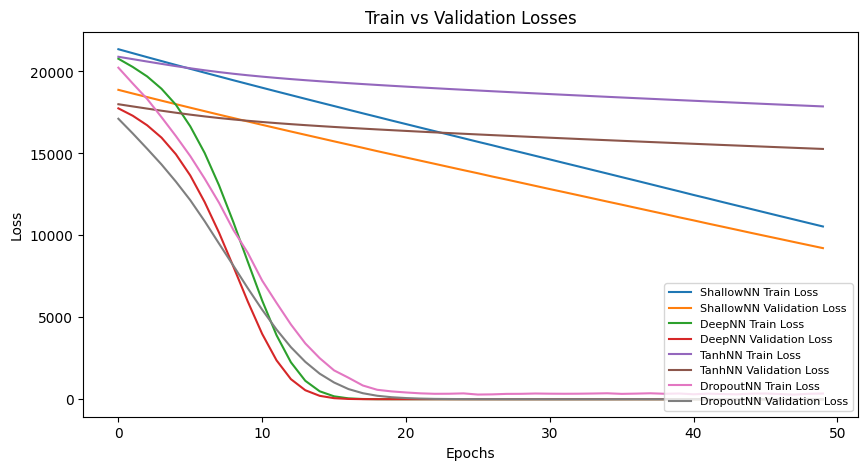

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_shallow, label="ShallowNN Train Loss")
plt.plot(val_losses_shallow, label="ShallowNN Validation Loss")
plt.plot(train_losses_deep, label="DeepNN Train Loss")
plt.plot(val_losses_deep, label="DeepNN Validation Loss")
plt.plot(train_losses_tanh, label="TanhNN Train Loss")
plt.plot(val_losses_tanh, label="TanhNN Validation Loss")
plt.plot(train_losses_dropout, label="DropoutNN Train Loss")
plt.plot(val_losses_dropout, label="DropoutNN Validation Loss")
plt.title("Train vs Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower right", fontsize=8)
plt.show()

### **Test All Models**

In [20]:
# Shallow network
test_loss_shallow, all_targets_shallow, all_predictions_shallow = test_model(shallow_model, test_loader, criterion, optimizer_shallow)
print(f"Shallow Test Loss: {test_loss_shallow:.5f}")

# Deep network
test_loss_deep, all_targets_deep, all_predictions_deep = test_model(deep_model, test_loader, criterion, optimizer_deep)
print(f"Deep Test Loss: {test_loss_deep:.5f}")

# Tanh network
test_loss_tanh, all_targets_tanh, all_predictions_tanh = test_model(tanh_model, test_loader, criterion, optimizer_tanh)
print(f"Tanh Test Loss: {test_loss_tanh:.5f}")

# Dropout network
test_loss_dropout, all_targets_dropout, all_predictions_dropout = test_model(dropout_model, test_loader, criterion, optimizer_dropout)
print(f"Dropout Test Loss: {test_loss_dropout:.5f}")

Shallow Test Loss: 10336.24023
Deep Test Loss: 0.04771
Tanh Test Loss: 17482.05957
Dropout Test Loss: 3.28526


### **Compare Predictions of All Models**

**Prepare Targets and Predictions**

In [21]:
# Sort targets for better visualization
all_targets_shallow = torch.cat(all_targets_shallow).numpy()
indices = np.argsort(all_targets_shallow)
all_targets_shallow = all_targets_shallow[indices]

# Shallow network
all_predictions_shallow = torch.cat(all_predictions_shallow).numpy()
all_predictions_shallow = all_predictions_shallow[indices]

# Deep network
all_predictions_deep = torch.cat(all_predictions_deep).numpy()
all_predictions_deep = all_predictions_deep[indices]

# Tanh network
all_predictions_tanh = torch.cat(all_predictions_tanh).numpy()
all_predictions_tanh = all_predictions_tanh[indices]

# Dropout network
all_predictions_dropout = torch.cat(all_predictions_dropout).numpy()
all_predictions_dropout = all_predictions_dropout[indices]

**Plot Targets and Predictions**

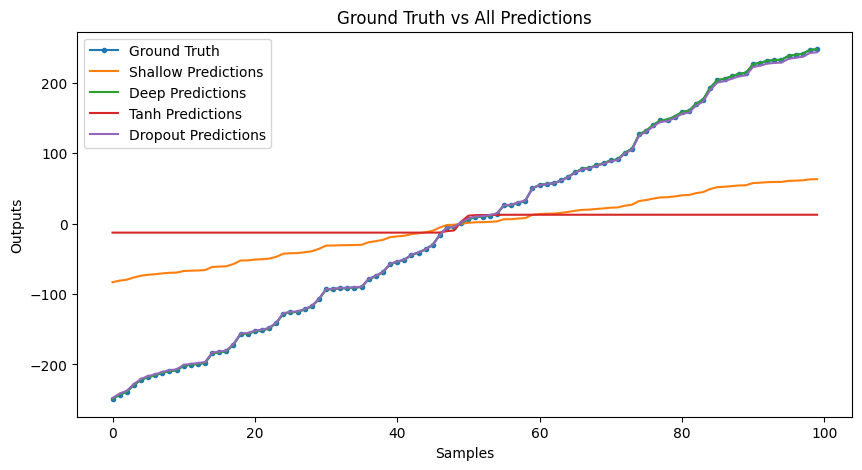

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(all_targets_shallow, label="Ground Truth", marker=".")
plt.plot(all_predictions_shallow, label="Shallow Predictions")
plt.plot(all_predictions_deep, label="Deep Predictions")
plt.plot(all_predictions_tanh, label="Tanh Predictions")
plt.plot(all_predictions_dropout, label="Dropout Predictions")
plt.title("Ground Truth vs All Predictions")
plt.xlabel("Samples")
plt.ylabel("Outputs")
plt.legend()
plt.show()